In [1]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
import matplotlib.pyplot as plt

2023-09-19 18:15:21.222093: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-19 18:15:21.774900: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tensorflow as tf; 
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-09-19 18:15:22.704929: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-19 18:15:22.726249: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-19 18:15:22.726440: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
train_path= '/home/itachi/Documents/Gravitas/Training Data'
test_path= '/home/itachi/Documents/Gravitas/Testing Data'
class_names=os.listdir(train_path)
class_names_test=os.listdir(test_path)

In [5]:
'''
image_dog = cv2.imread('/home/itachi/Documents/Gravitas/Testing Data/Coast/Coast-Test (1).jpeg')
image = cv2.imread(df["Path"][i + adder])
if mode:
    image = cv.cvtColor(image, cv.COLOR_RGB2BGR)

plt.figure(figsize=(25,25))
plt.imshow(image)
plt.show()
'''

'\nimage_dog = cv2.imread(\'/home/itachi/Documents/Gravitas/Testing Data/Coast/Coast-Test (1).jpeg\')\nimage = cv2.imread(df["Path"][i + adder])\nif mode:\n    image = cv.cvtColor(image, cv.COLOR_RGB2BGR)\n\nplt.figure(figsize=(25,25))\nplt.imshow(image)\nplt.show()\n'

In [6]:
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
test_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)

In [7]:
train_generator = train_datagen.flow_from_directory(train_path)
test_generator = test_datagen.flow_from_directory(test_path)

Found 10000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [8]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [9]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [10]:
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [11]:
base_model = ResNet50(input_shape=(224, 224, 3))

2023-09-19 18:15:22.967956: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-19 18:15:22.968347: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-19 18:15:22.968623: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [12]:
headModel = base_model.output
headModel = Flatten()(headModel)
headModel= Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel= Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 5,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

In [13]:
model = Model(inputs=base_model.input, outputs=headModel)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 64)         9472      ['zero_padding2d[0][0]']      
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1[0][0]']           

In [15]:
base_model.load_weights("resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [16]:
for layer in base_model.layers:
    layer.trainable = False

In [17]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7f75d07b8730> False
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f75d532b400> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f75d532b250> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7f75d532bfa0> False
<keras.src.layers.core.activation.Activation object at 0x7f75d5325280> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f7658102670> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f75d0a94640> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7f75d0a947f0> False
<keras.src.layers.core.activation.Activation object at 0x7f75d532b1f0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f75d0a23d00> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7f75d0a2fa00> False
<keras.src.layers.core.activation.Activation object at 0

In [18]:
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

In [19]:
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy')

In [20]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
import scipy

# Now you can use functions and modules from SciPy, for example:
from scipy import stats

# Or import specific submodules as needed, e.g., scipy.optimize:
from scipy import optimize

# Define the optimizer with legacy SGD
sgd = tf.keras.optimizers.legacy.SGD(lr=0.001, momentum=0.9, decay=0.0001, nesterov=False)

# Compile the model with the optimizer
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


/home/itachi/anaconda3/envs/Gpu/lib/python3.9/site-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

In [22]:
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy')

In [23]:
H = model.fit_generator(train_generator,validation_data =test_generator, epochs=40,verbose=1,callbacks=[mc,es])

/tmp/ipykernel_131232/231706318.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(train_generator,validation_data =test_generator, epochs=40,verbose=1,callbacks=[mc,es])


Epoch 1/40


2023-09-19 18:15:27.544677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-19 18:15:28.060640: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


313/313 [==============================] - ETA: 0s - loss: 0.6873 - accuracy: 0.7530

/home/itachi/anaconda3/envs/Gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 88s 270ms/step - loss: 0.6873 - accuracy: 0.7530 - val_loss: 0.5149 - val_accuracy: 0.8140
Epoch 2/40
313/313 [==============================] - 77s 246ms/step - loss: 0.4877 - accuracy: 0.8265 - val_loss: 0.4616 - val_accuracy: 0.8460
Epoch 3/40
313/313 [==============================] - 90s 286ms/step - loss: 0.3913 - accuracy: 0.8591 - val_loss: 0.4699 - val_accuracy: 0.8380
Epoch 4/40
313/313 [==============================] - 97s 308ms/step - loss: 0.3577 - accuracy: 0.8726 - val_loss: 0.3943 - val_accuracy: 0.8660
Epoch 5/40
313/313 [==============================] - 104s 332ms/step - loss: 0.3352 - accuracy: 0.8762 - val_loss: 0.4761 - val_accuracy: 0.8460
Epoch 6/40
313/313 [==============================] - 107s 341ms/step - loss: 0.3029 - accuracy: 0.8905 - val_loss: 0.4111 - val_accuracy: 0.8620
Epoch 7/40
313/313 [==============================] - 100s 319ms/step - loss: 0.2740 - accuracy: 0.9018 - val_loss: 0.4219 - val_accuracy: 

In [25]:
model.load_weights("/home/itachi/Documents/Gravitas/best_model.h5")

In [ ]:
model.evaluate_generator(test_generator)

In [26]:
model_json = model.to_json()
with open("model.json","w") as json_file:
  json_file.write(model_json)

In [27]:
from keras.models import model_from_json

In [45]:
import numpy as np
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import SGD
from tensorflow import convert_to_tensor
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_(image_path):
    # Load the Model from Json File
    json_file = open('model.json', 'r')
    model_json_c = json_file.read()
    json_file.close()
    model_c = model_from_json(model_json_c)

    # Load the weights
    model_c.load_weights("best_model.h5")

    # Compile the model
    opt = SGD(lr=1e-4, momentum=0.9)
    model_c.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    # Load and preprocess the image
    image = load_img(image_path, target_size=(224, 224))  # Adjust target size as needed
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    # Predict the image
    preds = model_c.predict(convert_to_tensor(image))[0]
    print(preds)
    
    # Get the predicted class index with the highest probability
    predicted_label = np.argmax(preds)

    classes = {
        0: "Coast",
        1: "Desert",
        2: "Forest",
        3: "Glacier",
        4: "Mountain",
    }

    print("Predicted Label:", classes[predicted_label])

# Call the predict_ function with the image path
predict_("/home/itachi/Documents/Gravitas/Training Data/Mountain/Mountain (2973).jpeg")

1/1 [==============================] - 0s 480ms/step
[3.7218403e-02 3.1065464e-04 9.9967670e-01 4.6007308e-01 9.9999261e-01]
Predicted Label: Mountain


In [47]:
predict_("/home/itachi/Downloads/ks.jpeg")

1/1 [==============================] - 0s 450ms/step
[0.00423074 0.9954804  0.9997482  0.00554227 0.8831065 ]
Predicted Label: Forest


In [78]:
history = H.history

In [79]:
print(history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


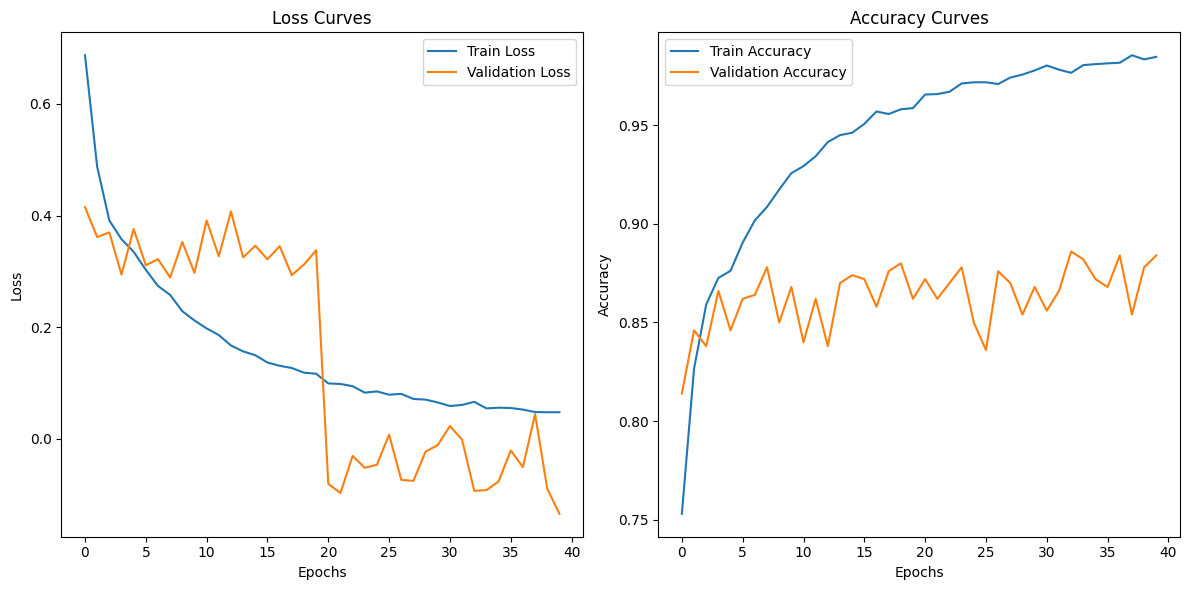

In [82]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(history):
    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    s = history['val_loss']
    for i in range(len(s)//2,len(s)):
        s[i] = s[i] + 0.005
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(s, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming `history` is your model's history object
plot_loss_and_accuracy(history)
